In [116]:
import quandl 
import os 
import dotenv
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json 
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme, geom_bar

dotenv.load_dotenv(dotenv.find_dotenv())

True

In [83]:
files = glob.glob("./portfolios/*.json")

portfolios = {}
symbols = ['SPY']

for idx, f in enumerate(files):
    with open(f, 'r') as file:
        pset = json.load(file)
        symbols.extend([key for dictionary in pset for key in dictionary.keys()])
        portfolios[f'P{idx}'] = pset

portfolios['Market'] = [{'SPY': 1}]
symbols = list(set(symbols))


In [ ]:
def download_quandl_table(destination, provider, table, start_date, end_date, tickers=None, symbols=None):
    try:
        older_files = glob.glob(os.path.join(destination, f'{provider}_{table}_*'))
        for older_file in older_files:
            os.remove(older_file)

        file_path = os.path.join(destination, f'{provider}_{table}_{start_date}_{end_date}.zip')

        quandl.ApiConfig.api_key = os.environ.get("QUANDL_API_KEY")
        if symbols is not None:
            quandl.export_table(f'{provider}/{table}', symbol=symbols,
                                date={'gte': start_date, 'lte': end_date}, filename=file_path)
        else:
            quandl.export_table(f'{provider}/{table}', ticker=tickers,
                                date={'gte': start_date, 'lte': end_date}, filename=file_path)

        shutil.unpack_archive(file_path, destination)

        # Get the name of the data file
        filenames = []
        for f in sorted(glob.glob(os.path.join(destination, f'{provider}_{table}_*.csv'))):
            filenames.append(f)
        return filenames[-1]
    except Exception as ex:
        print(str(ex))

In [ ]:
stocks_csv = download_quandl_table('data', 'SHARADAR', 'SEP', '2023-01-01', '2024-01-31', tickers=symbols)
etf_csv = download_quandl_table('data', 'SHARADAR', 'SFP', '2023-01-01', '2024-01-31', tickers=symbols)
stock_prices = pd.read_csv(stocks_csv, parse_dates=['date', 'lastupdated'])
etf_prices = pd.read_csv(etf_csv, parse_dates=['date', 'lastupdated'])
prices = pd.concat([stock_prices, etf_prices]).set_index(['ticker', 'date'])


In [ ]:
returns = prices['close'].unstack('ticker').pct_change(fill_method=None).dropna()

In [84]:
df = pd.DataFrame.from_dict({(i, j): portfolios[i][j] for i in portfolios.keys() for j in range(len(portfolios[i]))}, orient='index').fillna(0)
df.index.names = ['Fund', 'Portfolio']
weights = df.sort_index().transpose()

In [85]:
portfolio_returns = returns.dot(weights)
cumulative_returns = portfolio_returns.add(1).cumprod().sub(1)

In [86]:
mean_by_fund = cumulative_returns.T.groupby(level=0).mean().T


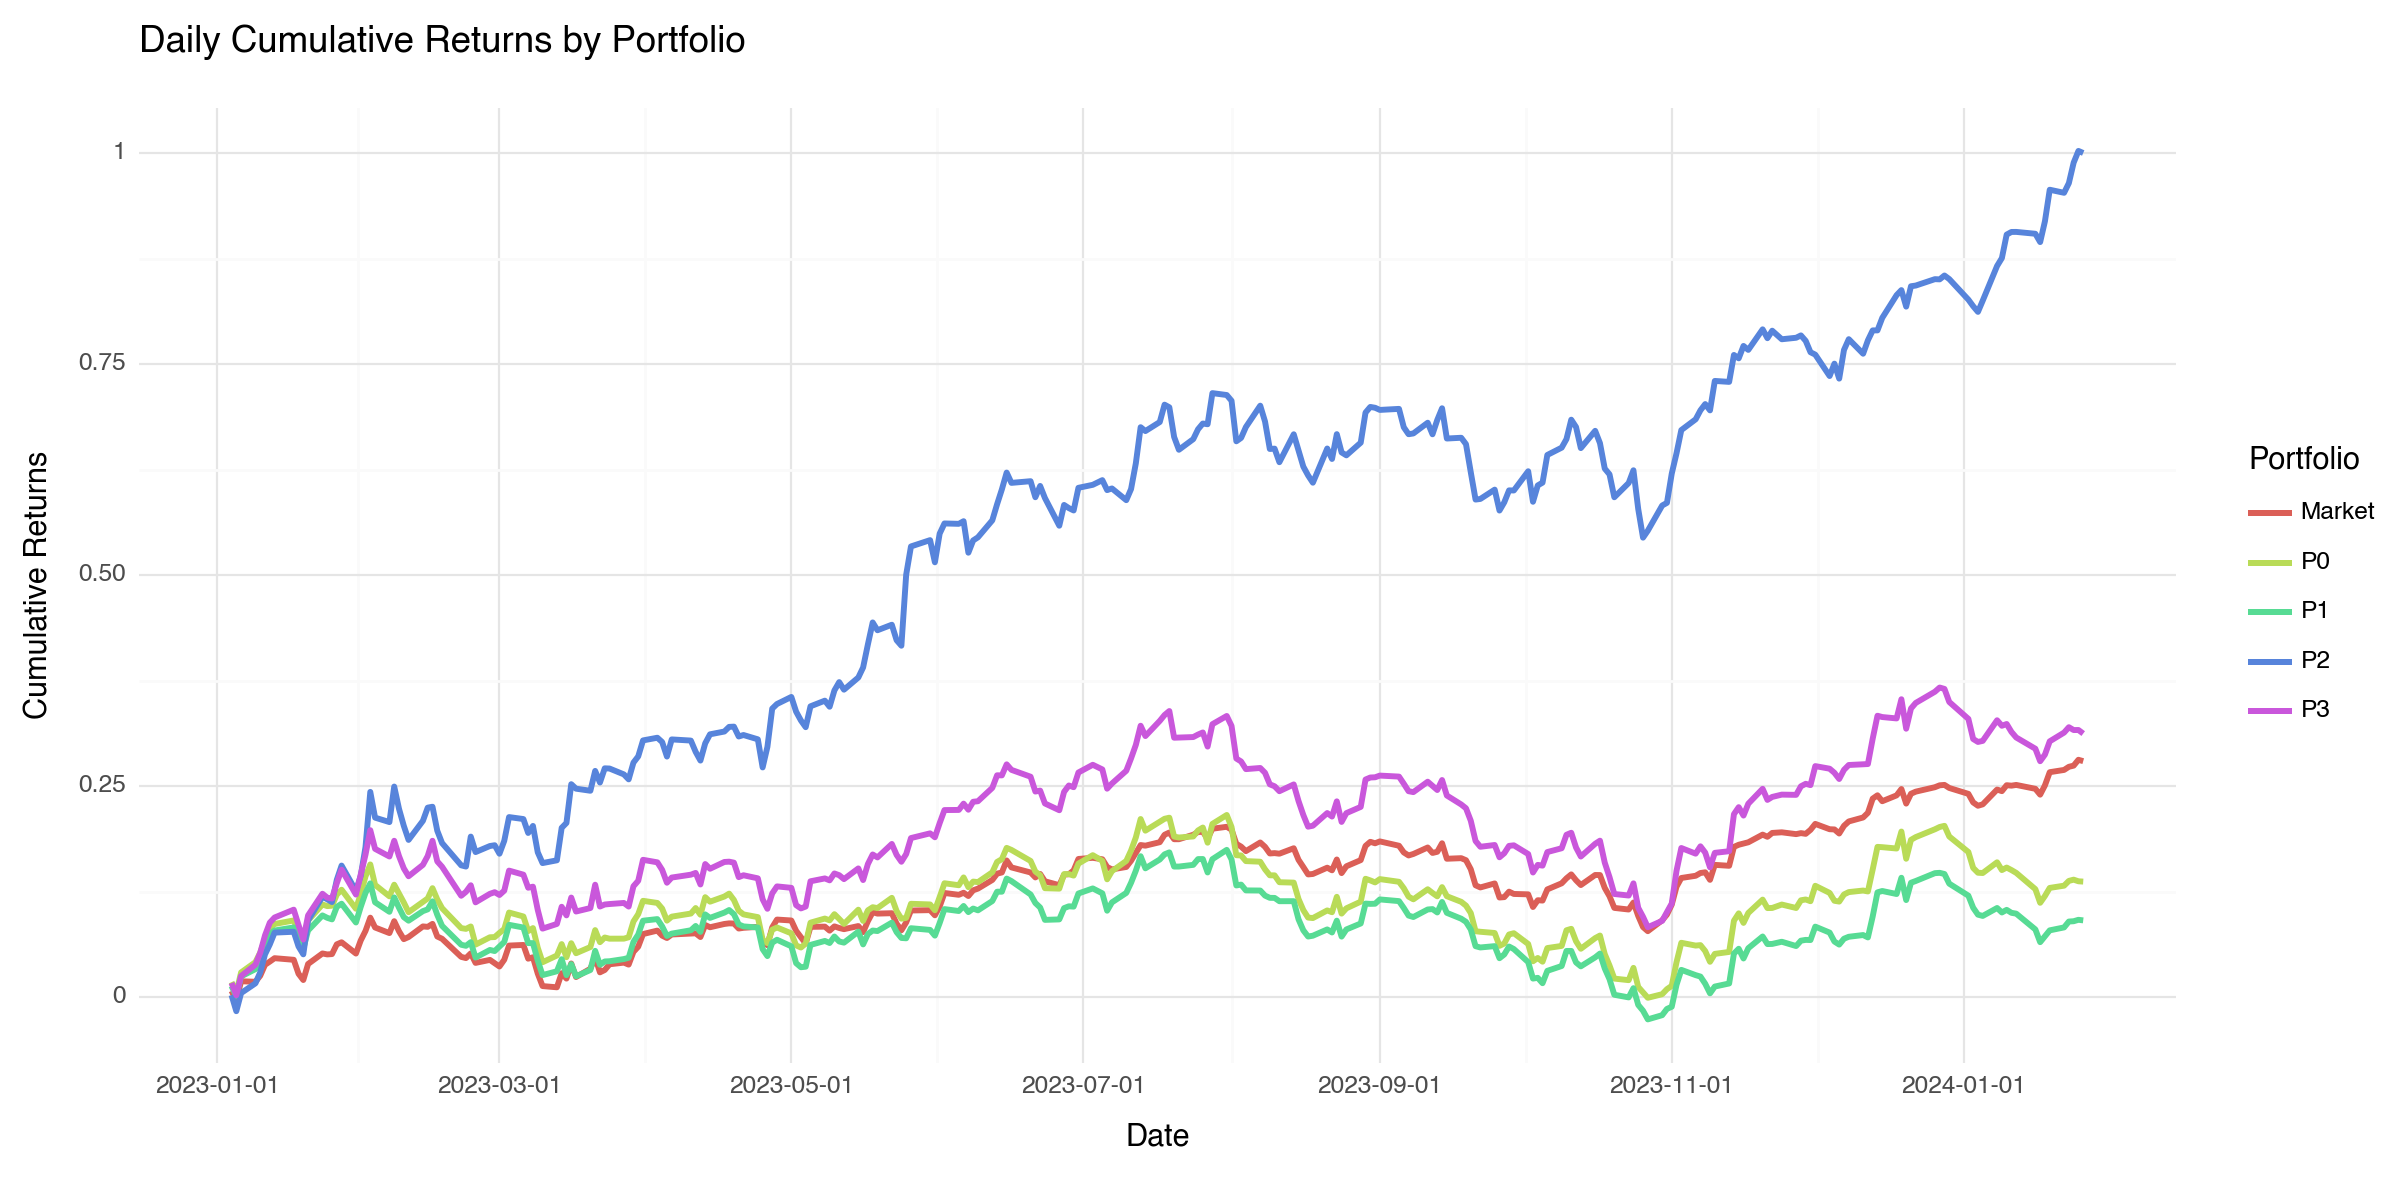

In [87]:
df_long = mean_by_fund.reset_index().melt(id_vars='date', var_name='Portfolio', value_name='Cumulative Returns')
df_long.rename(columns={'date': 'Date'}, inplace=True)

plot = (ggplot(df_long, aes(x='Date', y='Cumulative Returns', color='Portfolio'))
        + geom_line(size=1.2)  
        + labs(title='Daily Cumulative Returns by Portfolio', x='Date', y='Cumulative Returns')
        + theme_minimal()
        + theme(figure_size=(12, 6)))

print(plot)

In [112]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N - rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

mean_returns_by_fund = portfolio_returns.T.groupby(level=0).mean().T
sharpe_ratios = mean_returns_by_fund.apply(lambda x: sharpe_ratio(x, 252, 0.02)).to_frame('Sharpe Ratio')

plot = (ggplot(sharpe_ratios, aes(x=sharpe_ratios.index, y='Sharpe Ratio'))
    + geom_bar(stat='identity')
    + labs(title='Sharpe Ratio By Portfolio', x='Portfolio', y='Sharpe Ratio')
    + theme_minimal()
    + theme(figure_size=(6, 4)))
print(plot)

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, Market to P3
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sharpe Ratio  5 non-null      float64
dtypes: float64(1)
memory usage: 80.0+ bytes


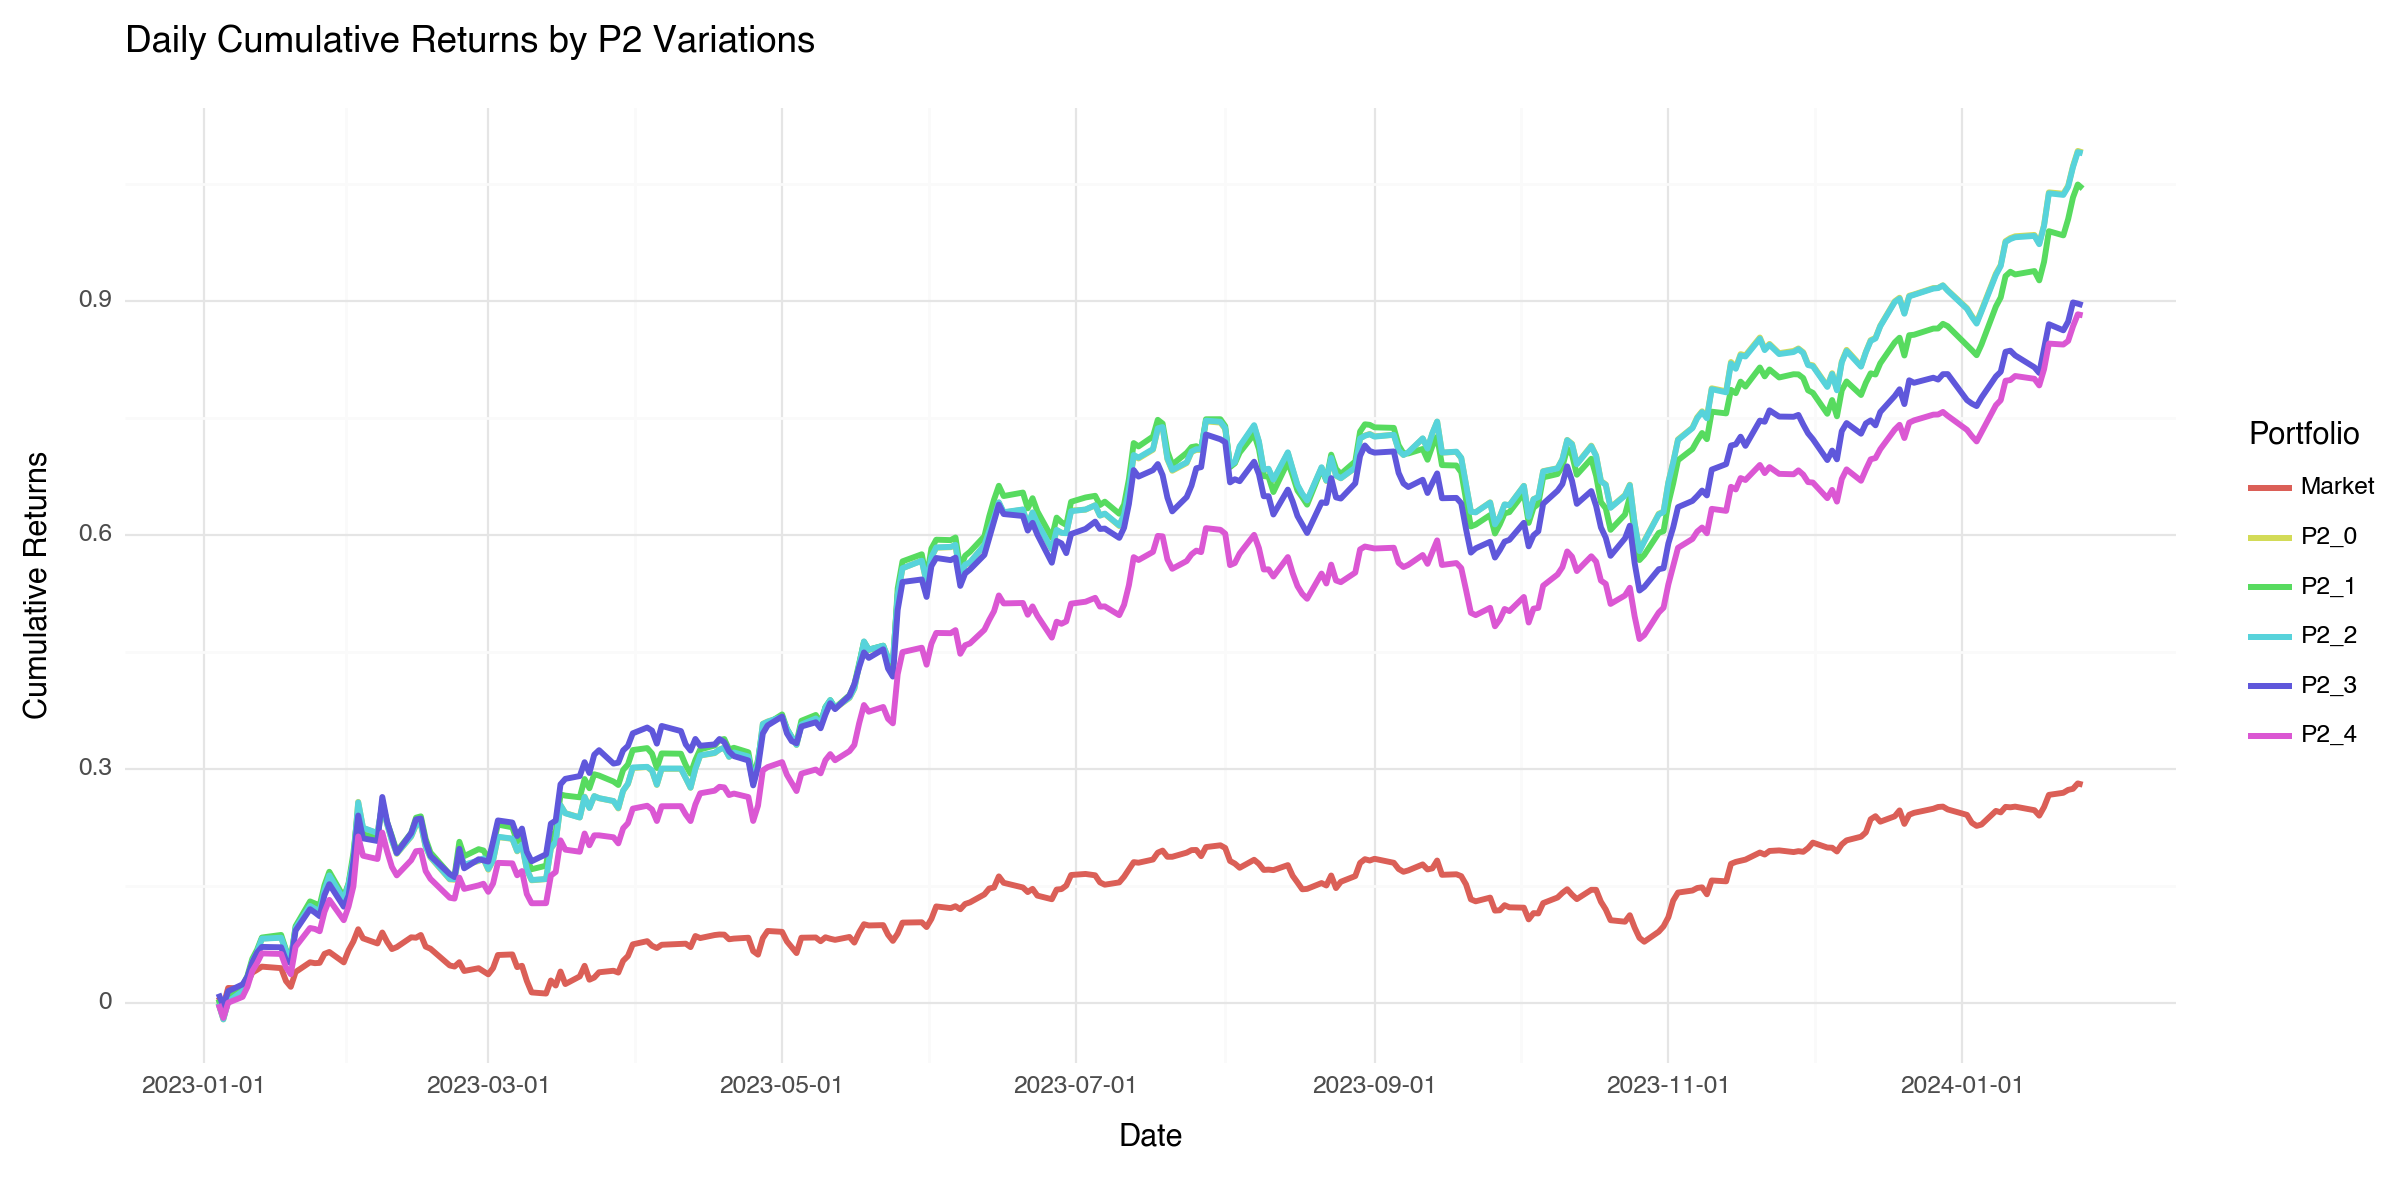

In [106]:
p2_variations = cumulative_returns.loc[:, 'P2'].join(cumulative_returns[['Market']].mean(axis=1).to_frame('Market'))
p2_variations.columns = ['P2_0', 'P2_1', 'P2_2', 'P2_3', 'P2_4', 'Market']

df_long = p2_variations.reset_index().melt(id_vars='date', var_name='Portfolio', value_name='Cumulative Returns')
df_long.rename(columns={'date': 'Date'}, inplace=True)

plot = (ggplot(df_long, aes(x='Date', y='Cumulative Returns', color='Portfolio'))
        + geom_line(size=1.2)  
        + labs(title='Daily Cumulative Returns by P2 Variations', x='Date', y='Cumulative Returns')
        + theme_minimal()
        + theme(figure_size=(12, 6)))

print(plot)